Before running the code blocks, run the following commands to get the kernel prepared:
```sh
julia
import Pkg
Pkg.update()
Pkg.precompile()

using Pkg
Pkg.build("IJulia")
```

In [25]:
using HDF5
using Serialization
using DataFrames, Plots, Statistics
using Plots.PlotMeasures 
using DataFramesMeta

In [3]:
function timer_dict_to_df(timer_dict, optimization, flatten=false)
    rows = []

    for (trial, ranks) in timer_dict
        n_important_prt, total_rank, nprt_per_rank, n_float_per_particle, perm = split(trial, ":")
        n_important_prt = n_important_prt == "half" ? "50%" : n_important_prt
        trial_name = "$n_important_prt particles"
        for (rank, timers) in ranks
            # push the overall timer
            push!(rows, (
                optimization = optimization,
                trial  = String(trial_name),
                perm = String(perm),
                total_rank = parse(Int, total_rank),
                particle_size = n_float_per_particle,
                nprt_per_rank = nprt_per_rank,
                rank   = string(rank),
                op     = "overall",
                metric = "time_micros",
                value  = timers["total_time_ns"] / 1e3
            ))
            push!(rows, (
                optimization = optimization,
                trial  = String(trial_name),
                perm = String(perm),
                total_rank = parse(Int, total_rank),
                particle_size = n_float_per_particle,
                nprt_per_rank = nprt_per_rank,
                rank   = string(rank),
                op     = "overall",
                metric = "n_calls",
                value  = timers["n_calls"]
            ))
            for (op, metrics) in timers["inner_timers"]
                # Flatten inner timers for receive loop
                if op == "receive loop" && flatten
                    for (inner_op, inner_metrics) in metrics["inner_timers"]
                        for (metric, value) in inner_metrics
                            if metric == "time_ns"
                                value = value / 1e3 # Convert nanoseconds to microseconds
                                metric = "time_micros"
                            end
                            push!(rows, (
                                optimization = optimization,
                                trial  = String(trial_name),
                                perm = String(perm),
                                total_rank = parse(Int, total_rank),
                                particle_size = n_float_per_particle,
                                nprt_per_rank = nprt_per_rank,
                                rank   = string(rank),
                                op     = String(inner_op),
                                metric = String(metric),
                                value  = value,
                            ))
                        end
                    end
                end
                for (metric, value) in metrics
                    if metric == "inner_timers"
                        continue # Skip the inner_timers key
                    end
                    if metric == "time_ns"
                        value = value / 1e3 # Convert nanoseconds to microseconds
                        metric = "time_micros"
                    end
                    push!(rows, (
                        optimization = optimization,
                        trial  = String(trial_name),
                        perm = String(perm),
                        total_rank = parse(Int, total_rank),
                        particle_size = n_float_per_particle,
                        nprt_per_rank = nprt_per_rank,
                        rank   = string(rank),
                        op     = String(op),
                        metric = String(metric),
                        value  = value,
                    ))
                end
            end
        end
    end
    return DataFrame(rows)
end

timer_dict_to_df (generic function with 2 methods)

In [4]:
function render(df, label=false)
  trials = unique(df.trial)
  ops    = unique(df.op)

  ntrials, nops = length(trials), length(ops)

  # 2) Create an empty grid, with row & column titles
  plt = plot(
    layout     = (ntrials, nops),
    legend = label ? :topleft : :none,
    size       = (300 * nops, 300 * ntrials),
  )

  # 3) Fill it in
  for (i, trial) in enumerate(trials)
    for (j, op) in enumerate(ops)
      sub = df[(df.trial .== trial) .& (df.op .== op), :]
      for rk in unique(sub.rank)
        subrk = sub[sub.rank .== rk, :]
        scatter!(
          plt[i, j],
          string.(subrk.total_rank),    # categorical x
          subrk.time_micros;
          marker     = :circle,
          markersize = 4,
          label      = rk,
          right_margin = 10mm,
          color      = rk == "0" ? :blue : :orange,
        )
      end
      plot!(plt[i, j], title = string(op), top_margin = 10mm)
      if j == 1
        plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
      end

      # only the bottom row gets the shared x‐axis label
      if i == ntrials
        plot!(plt[i, j], xlabel = "Total Rank")
      end
    end
  end

  display(plt)
  return plt
end

render (generic function with 2 methods)

In [76]:
function df_from_h5(category)

    # TODO: fix this
    optimization = if category == "output_n_float_1000"
        "original_1k"
    elseif category == "output_n_float_100k"
        "original_100k"
    elseif category == "output_n_float100k_dedup"
        "dedup_100k"
    elseif category == "output_n_float_100k_dedup_threads"
        "dedup_threads_100k"
    elseif category == "output_n_float_100k_dedup_threads_writebuf"
        "dedup_threads_100k"
    else
        error("Unknown category: $category")
    end

    root = dirname(@__FILE__)
    h5path(rank) = joinpath(root, "../test/$(category)/", "all_timers_$(rank).h5") 
    all_timer_dfs = DataFrame()
    for rank in [2, 4, 8, 16]
        blob = h5open(h5path(rank)) do f
            read(f, "all_timers")
        end

        # Deserialize back into Dict{String,Dict{Int,Dict{String,Any}}}
        merged_timers = deserialize(IOBuffer(blob))

        # Convert to DataFrame
        timer_df = timer_dict_to_df(merged_timers, optimization)
        
        # Concat to all_timer_dfs
        all_timer_dfs = vcat(all_timer_dfs, timer_df)
    end

    wide = unstack(
    all_timer_dfs,
    [:optimization, :trial, :perm, :total_rank, :nprt_per_rank, :particle_size, :rank, :op],
    :metric,
    :value
    )

    # Compute the average time per call
    wide.time_micros .= wide.time_micros ./ wide.n_calls
    # Sort by perm and trial
    wide = sort!(wide, [:perm, :trial])

    first_df = wide[wide.perm .== "firstperm", :]
    rand_df = wide[wide.perm .== "randperm", :]
    return (first_df, rand_df)
end

df_from_h5 (generic function with 1 method)

In [90]:

# _, original_1k_df = df_from_h5("output_n_float_1000")
_, original_100k_df = df_from_h5("output_n_float_100k")
_, dedup_100k_df = df_from_h5("output_n_float100k_dedup")
_, dedup_threads_100k_df = df_from_h5("output_n_float_100k_dedup_threads_writebuf")
# dedup_100k_df

# println("Picking particles from the beginning")
# savefig(render(first_df), joinpath(root, "firstperm_plot.png"))
# println("Picking particles randomly")
# savefig(render(original_1k_df), joinpath(root, "randperm_plot.png"))

# union dataframes
union_df = vcat(original_100k_df, dedup_100k_df, dedup_threads_100k_df)
# println("1k original")
# render(original_1k_df)
# println("100k original")
# render(original_100k_df)
# println("100k dedup")
# render(dedup_100k_df)
# render(dedup_threads_100k_df)


3450×13 DataFrame
  Row │ optimization        trial          perm      total_rank  nprt_per_rank ⋯
      │ String              String         String    Int64       SubString…    ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ original_100k       1 particles    randperm           2  1000          ⋯
    2 │ original_100k       1 particles    randperm           2  1000
    3 │ original_100k       1 particles    randperm           2  1000
    4 │ original_100k       1 particles    randperm           2  1000
    5 │ original_100k       1 particles    randperm           2  1000          ⋯
    6 │ original_100k       1 particles    randperm           2  1000
    7 │ original_100k       1 particles    randperm           2  1000
    8 │ original_100k       1 particles    randperm           2  1000
    9 │ original_100k       1 particles    randperm           2  1000          ⋯
   10 │ original_100k       1 particles    randperm           2  1000
   11 │ original_100k       1 particles    randperm           4  1000
  ⋮   │         ⋮                 ⋮           ⋮          ⋮             ⋮       ⋱
 3441 │ dedup_threads_100k  all particles  randperm          16  1000
 3442 │ dedup_threads_100k  all particles  randperm          16  1000          ⋯
 3443 │ dedup_threads_100k  all particles  randperm          16  1000
 3444 │ dedup_threads_100k  all particles  randperm          16  1000
 3445 │ dedup_threads_100k  all particles  randperm          16  1000
 3446 │ dedup_threads_100k  all particles  randperm          16  1000          ⋯
 3447 │ dedup_threads_100k  all particles  randperm          16  1000
 3448 │ dedup_threads_100k  all particles  randperm          16  1000
 3449 │ dedup_threads_100k  all particles  randperm          16  1000
 3450 │ dedup_threads_100k  all particles  randperm          16  1000          ⋯
                                                 8 columns and 3429 rows omitted

In [106]:
function stats(df)
    df_writefrombuf = df |>
                 df_filtered -> filter(:op => x -> x .== "write from buffer", df_filtered) |>
                 df_final -> select(df_final,
                                    :optimization, :trial, :total_rank, :rank,
                                    :time_micros => (t -> t ./ 1e3) => :writefrombuf_time_ms)

    df_waitall = df |>
                 df_filtered -> filter(:op => x -> x .== "waitall", df_filtered) |>
                 df_final -> select(df_final,
                                    :optimization, :trial, :total_rank, :rank,
                                    :time_micros => (t -> t ./ 1e3) => :waitall_time_ms)
    
    df_remotedup = df |>
                 df_filtered -> filter(:op => x -> x .== "remote duplicates copy", df_filtered) |>
                 df_final -> select(df_final,
                                    :optimization, :trial, :total_rank, :rank,
                                    :time_micros => (t -> t ./ 1e3) => :remotedup_time_ms)
    
    df_localcopy = df |>
                 df_filtered -> filter(:op => x -> x .== "local copies", df_filtered) |>
                 df_final -> select(df_final,
                                    :optimization, :trial, :total_rank, :rank,
                                    :time_micros => (t -> t ./ 1e3) => :localcopy_time_ms)

    df_overall = df |>
                 df_filtered -> filter(:op => x -> x .== "overall", df_filtered) |>
                 df_final -> select(df_final,
                                    :optimization, :trial, :total_rank, :rank,
                                    :time_micros => (t -> t ./ 1e3) => :overall_time_ms)
    df_stats = leftjoin(df_waitall, df_overall, on=[:optimization, :trial, :total_rank, :rank])
    leftjoin!(df_stats, df_remotedup, on=[:optimization, :trial, :total_rank, :rank])
    leftjoin!(df_stats, df_localcopy, on=[:optimization, :trial, :total_rank, :rank])
    leftjoin!(df_stats, df_writefrombuf, on=[:optimization, :trial, :total_rank, :rank])

    df_stats = @chain df_stats[df_stats.total_rank .> 1, :] begin
        @transform(
            :waitall_ratio = :waitall_time_ms ./ :overall_time_ms,
            :localcopy_ratio = :localcopy_time_ms ./ :overall_time_ms,
            :remotedup_ratio = :remotedup_time_ms ./ :overall_time_ms,
            :writefrombuf_ratio = :writefrombuf_time_ms ./ :overall_time_ms,
            :waitall_time_log = log2.(:waitall_time_ms),
            :overall_time_log = log2.(:overall_time_ms)
        )
        groupby([:optimization, :trial, :total_rank])
        @combine(
            :waitall_ratio_min = minimum(:waitall_ratio),
            :waitall_ratio_max = maximum(:waitall_ratio),
            :waitall_ratio_mean = mean(:waitall_ratio),
            :localcopy_ratio_mean = mean(:localcopy_ratio),
            :remotedup_ratio_mean = mean(:remotedup_ratio),
            :writefrombuf_ratio_mean = mean(:writefrombuf_ratio),
            :waitall_ratio_std  = std(:waitall_ratio),
            :waitall_log_time_min  = minimum(:waitall_time_log),
            :waitall_log_time_max  = maximum(:waitall_time_log),
            :waitall_log_time_mean  = mean(:waitall_time_log),
            :remotedup_time_mean  = mean(:remotedup_time_ms),
            :localcopy_time_mean  = mean(:localcopy_time_ms),
            :writefrombuf_time_mean  = mean(:writefrombuf_time_ms),
            :waitall_log_time_std   = std(:waitall_time_log),
            :overall_log_time_min  = minimum(:overall_time_log),
            :overall_log_time_max  = maximum(:overall_time_log),
            :overall_log_time_mean  = mean(:overall_time_log),
            :overall_log_time_std   = std(:overall_time_log)
        )
    end
    return df_stats
end

stats (generic function with 1 method)

In [104]:
function render_stats(df, label=false)
  trials = unique(df.trial)

  ntrials = length(trials)
  stats = ["waitall_ratio_mean", "writefrombuf_ratio_mean", "localcopy_ratio_mean", "remotedup_ratio_mean", "overall_log_time_mean", "waitall_log_time_mean", "writefrombuf_time_mean", "remotedup_time_mean", "localcopy_time_mean"]

  # 2) Create an empty grid, with row & column titles
  plt = plot(
    layout     = (ntrials, length(stats)),
    legend = label ? :outertop : :none,
    size       = (300 * length(stats), 300 * ntrials),
  )

  # 3) Fill it in
  for (i, trial) in enumerate(trials)
    for (j, stat) in enumerate(stats)
      df_filtered = df[df.trial .== trial, :]
      sub = select(df_filtered, :optimization, :total_rank, stat => :value)
      # draw a plot for value over total_rank
      for optimization in unique(sub.optimization)
        subrk = sub[sub.optimization .== optimization, :]
        plot!(
          plt[i, j],
          string.(subrk.total_rank),    # categorical x
          subrk.value;
          seriestype = :path,
          markersize = 4,
          label      = optimization,
          right_margin = 10mm
        )
      end
      plot!(plt[i, j], title = stat, top_margin = 10mm)
      if j == 1
        plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
      end

      # only the bottom row gets the shared x‐axis label
      if i == ntrials
        plot!(plt[i, j], xlabel = "Total Rank", bottom_margin = 10mm)
      end
    end
  end
  return plt
end

render_stats (generic function with 2 methods)

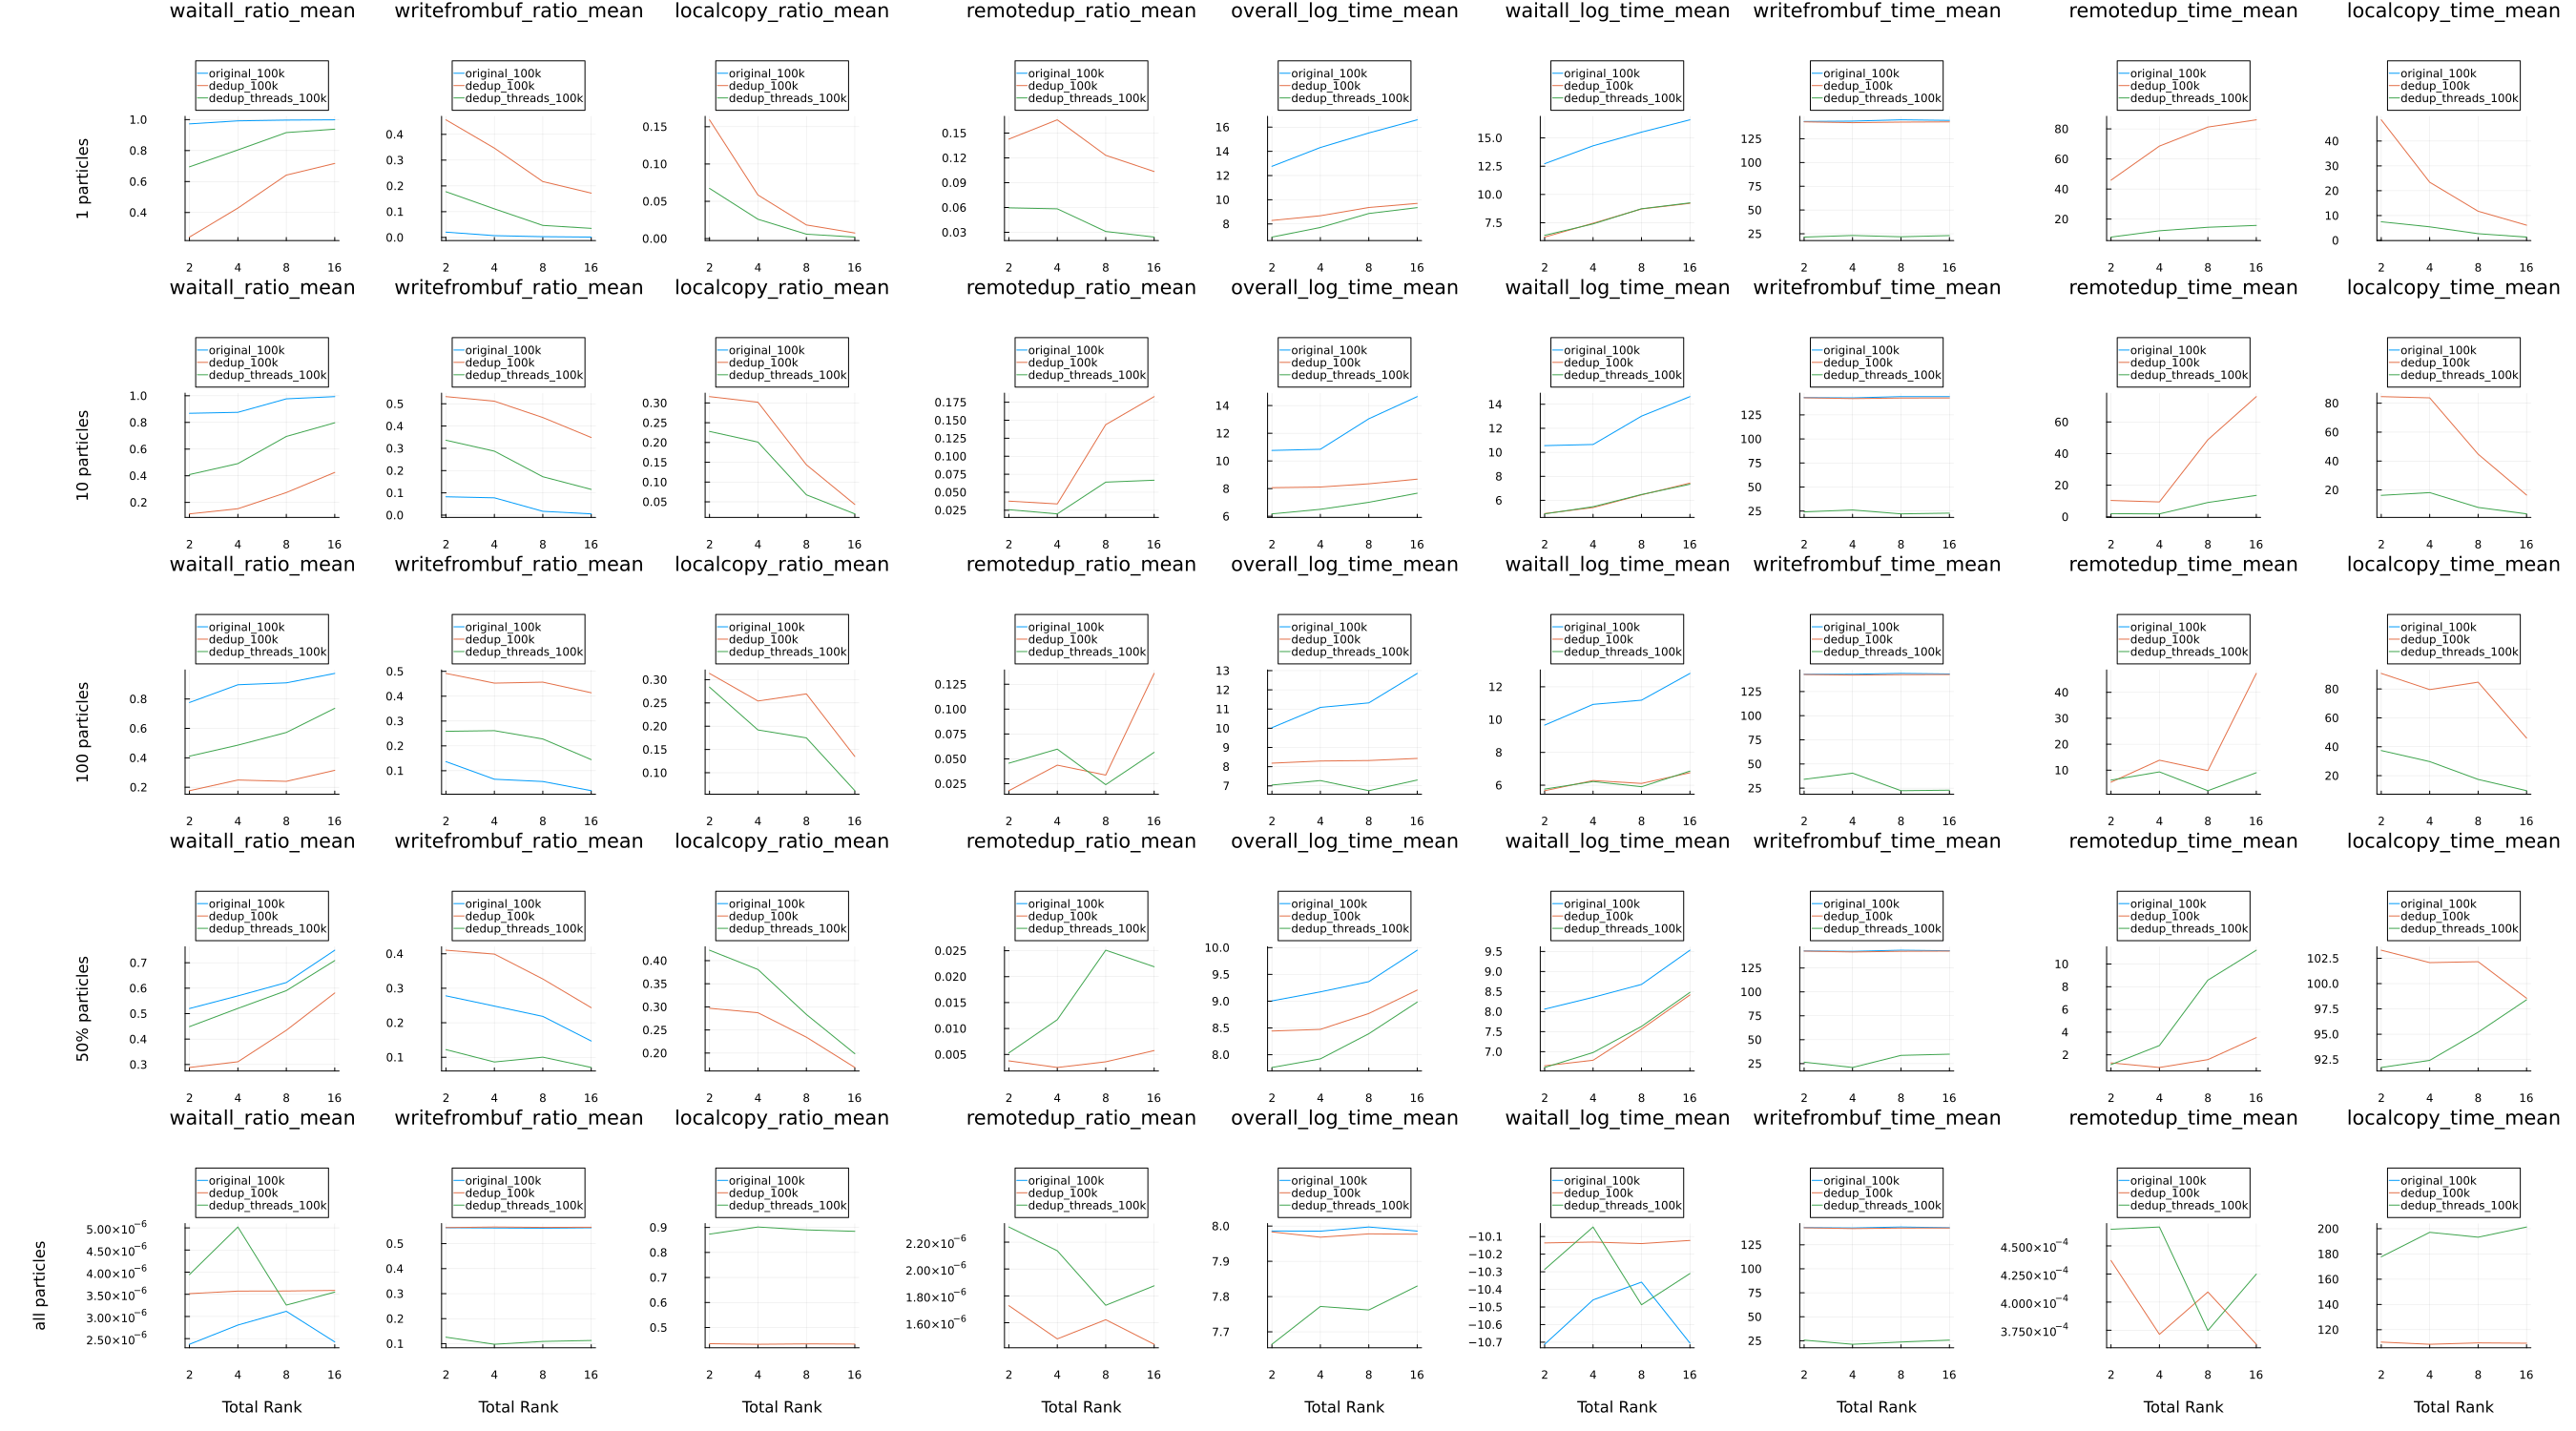

In [107]:
render_stats(stats(union_df), true)